In [1]:
from datasets import load_dataset

dataset = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [12]:
train_df=pd.DataFrame(dataset['train'])
train_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
train_df.shape

(8530, 2)

In [16]:
train_df["text"][1]
train_df["label"][1]

'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .'

1

In [17]:
train_df["label"].unique()

array([1, 0], dtype=int64)

In [18]:
#1 - positive sentiment
#0 - negative sentiment

In [19]:
#we first train a sequence autoencoder(unsupervised learning) on unlabeled data like rotten tomatoes and then train an lstm (supervised learning) with the weights obtained on the same rotten tomatoes dataset

In [20]:
train_df['text'] = train_df["text"].str.lower() #converting to lowercase
train_df['text'] = train_df['text'].str.replace('[^\w\s]','') #removing punctuation
train_df['text'] = train_df["text"].fillna("fillna") #filling empty values with "fillna"

train_df['text'].str.len().max()

267

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features=5000 #we set maximum number of words to 5000
max_sequence_length = 267 #we set maximum sequence length to 267

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['text'])) #fit to cleaned text

sequences = tokenizer.texts_to_sequences(train_df['text'])
X_train = pad_sequences(sequences, maxlen=max_sequence_length)

In [38]:
print("Number of unique words:", len(tokenizer.word_index))
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:",vocab_size)

Number of unique words: 17451
Vocab size: 17452


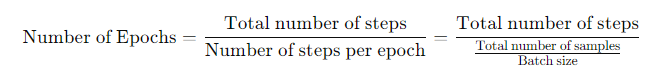

In [39]:
num_samples=8530
batch_size=128
num_steps=500000
num_steps_per_epoch=num_samples/batch_size

num_epochs=num_steps/num_steps_per_epoch
print(num_epochs)

num_epochs = 10 #for trial we have kept it as 10

7502.930832356389


In [41]:
#Step 1: Unsupervised training of sequence autoencoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, RepeatVector, Dense

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_sequence_length = 267 #we set maximum sequence length to 267
latent_dim = 64
num_epochs = 10 #for trial we have kept it as 10
batch_size=128

max_features=5000 #we set maximum number of words to 5000
max_sequence_length = 267


sequence_autoencoder = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(latent_dim, return_sequences=False),
    RepeatVector(max_sequence_length),
    LSTM(embedding_dim, return_sequences=True),
    TimeDistributed(Dense(vocab_size, activation='softmax'))   
])
sequence_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

#train the autoencoder to reconstruct the input sequences
sequence_autoencoder.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size) 

D:\ProgramFiles\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 913s 13s/step - loss: 7.3432
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 991s 15s/step - loss: 0.6914
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 956s 14s/step - loss: 0.6630
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 973s 15s/step - loss: 0.6592
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 982s 15s/step - loss: 0.6580
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 975s 15s/step - loss: 0.6526
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 971s 15s/step - loss: 0.6526
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 960s 14s/step - loss: 0.6535
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 983s 15s/step - loss: 0.6579
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 981s 15s/step - loss: 0.6504


In [53]:
sequence_autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 267, 100)            │       1,745,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 267, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 267, 100)            │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 267, 17452)          │       1,762,652 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,616,094 (13.79 MB)

 Trainable params: 3,616,092 (13.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [42]:
#training time took 2 hrs 40 mins approximately
#consumed 15.2 GB RAM

In [46]:
#Step 2: saving important files - model, tokenizer, autoencoder weights, embedding weights

tf.keras.models.save_model(sequence_autoencoder, "sequence_autoencoder.h5")

import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
sequence_autoencoder.save_weights('sequence_autoencoder_weights.h5', by_name=True)
embedding_layer = sequence_autoencoder.layers[0]
weights = embedding_layer.get_weights()[0]
np.save('embedding_weights.npy', weights)

In [54]:
#loading important files
#lstm.load_weights('sequence_autoencoder.weights.h5')

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
#embedding_weights = np.load('embedding_weights.npy')

In [58]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [73]:
test_df=pd.DataFrame(dataset['test'])
validation_df=pd.DataFrame(dataset['validation'])

test_df['text'] = test_df["text"].str.lower() #converting to lowercase
test_df['text'] = test_df['text'].str.replace('[^\w\s]','') #removing punctuation
test_df['text'] = test_df["text"].fillna("fillna") #filling empty values with "fillna"

validation_df['text'] = validation_df["text"].str.lower() #converting to lowercase
validation_df['text'] = validation_df['text'].str.replace('[^\w\s]','') #removing punctuation
validation_df['text'] = validation_df["text"].fillna("fillna") #filling empty values with "fillna"

sequences = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(sequences, maxlen=max_sequence_length)

sequences = tokenizer.texts_to_sequences(validation_df['text'])
X_validation = pad_sequences(sequences, maxlen=max_sequence_length)

In [64]:
sequence_autoencoder.save_weights('sequence_autoencoder.weights.h5')

In [74]:
#Step 3: Supervised training LSTM with the files

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_sequence_length = 267 #we set maximum sequence length to 267
latent_dim = 64
num_epochs = 10 #for trial we have kept it as 10
batch_size=128
hidden_units=512

max_features=5000 #we set maximum number of words to 5000
max_sequence_length = 267


from tensorflow.keras.models import load_model

autoencoder = load_model('sequence_autoencoder.h5')
autoencoder_weights = autoencoder.get_weights()


lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
        tf.keras.layers.Dropout(0.2),  # Random embedding dimension dropout
        tf.keras.layers.LSTM(hidden_units, return_sequences=False),
        tf.keras.layers.Dropout(0.2),  # Random word dropout
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

lstm.set_weights(autoencoder_weights[:len(lstm.get_weights())])

lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

lstm.fit(X_train, train_df['label'], epochs=5, batch_size=batch_size, validation_data=(X_validation, validation_df['label']))

Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5691 - loss: 0.6805 - val_accuracy: 0.7120 - val_loss: 0.5761
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8090 - loss: 0.4413 - val_accuracy: 0.7439 - val_loss: 0.5440
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8772 - loss: 0.2981 - val_accuracy: 0.7514 - val_loss: 0.5556
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9132 - loss: 0.2254 - val_accuracy: 0.7495 - val_loss: 0.6041
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9355 - loss: 0.1759 - val_accuracy: 0.7355 - val_loss: 0.6401


In [ ]:
#86.5% accuracy was achieved in the research paper
#93.55% accuracy achieved here

In [72]:
type(validation_df["label"][0])

numpy.int64

In [75]:
autoencoder_weights

[array([[ 0.39592922,  0.5772876 ,  0.7053559 , ...,  0.67533267,
         -0.05684252,  0.73298365],
        [ 0.212633  ,  0.22723812,  0.20427324, ...,  0.21888657,
         -0.15489164,  0.24696901],
        [ 0.18077843,  0.14869843,  0.17813063, ...,  0.16957606,
         -0.14441766,  0.23383829],
        ...,
        [ 0.02236493,  0.03365472, -0.01841827, ...,  0.03053704,
          0.02529789,  0.02370795],
        [-0.01577408,  0.00860023,  0.00862161, ..., -0.02099911,
         -0.02828485, -0.04547815],
        [-0.01326876,  0.00385417, -0.04392402, ...,  0.03544324,
         -0.02932066, -0.03779497]], dtype=float32),
 array([[-0.08175079, -0.00579493,  0.1156817 , ..., -0.01230864,
          0.07582035,  0.06588976],
        [ 0.04120396, -0.03511974,  0.13689657, ...,  0.06055572,
          0.0288223 ,  0.03052408],
        [ 0.13971968, -0.02095467,  0.03907078, ...,  0.1466614 ,
          0.00662451, -0.00728588],
        ...,
        [-0.10615106,  0.0168506 , -0.0

In [76]:
tf.keras.models.save_model(lstm, "lstm_model.h5")

In [92]:
train_df["text"][7000]
train_df["label"][7000]

"it won't be long before you'll spy i spy at a video store near you ."

0